# OTE Water Ice Measurements with NIRCam

This activity will use NIRCam longwave grism spectra to check for ice contamination associated with the telescope and instrument cooldown.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

# Program bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import webbpsf, poppy, S

pynrc.setup_logging('WARN', verbose=True)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
import os
from astropy.io import fits, ascii

In [4]:
webbpsf_data_path = webbpsf.utils.get_webbpsf_data_path()

# Pupil and segment information
pupil_file = os.path.join(webbpsf_data_path, "jwst_pupil_RevW_npix1024.fits.gz")
pupil_hdul = fits.open(pupil_file)

segmap_file = os.path.join(webbpsf_data_path, "JWpupil_segments_RevW_npix1024.fits.gz")
segmap_hdul = fits.open(segmap_file)

In [5]:
def segment_pupil_opd(hdu, segment_name):
    """Extract single segment pupil from input full OPD map"""
    
    from webbpsf.webbpsf_core import segname, one_segment_pupil
    
    if segment_name.upper()=='ALL':
        opd_im, opd_header = (hdu.data, hdu.header)

        # New Pupil HDUList
        hdu = fits.PrimaryHDU(pupil_hdul[0].data)
        hdu.header = pupil_hdul[0].header.copy()
        pupil_all_hdul = fits.HDUList([hdu])
        
        # New OPD HDUList
        hdu = fits.PrimaryHDU(opd_im * pupil_all_hdul[0].data)
        hdu.header = opd_header.copy()
        opd_all_hdul = fits.HDUList([hdu])
        
        return (pupil_all_hdul, opd_all_hdul)

    # Parse out segment number
    segment_official_name = segname(segment_name)
    # Parse out the segment number
    num = int(segment_official_name.split('-')[1])
    # Index of segment to grab
    iseg = num - 1

    # Pupil mask of segment only
    pupil_seg_hdul = one_segment_pupil(segment_name)
    
    opd_im, opd_header = (hdu.data, hdu.header)
    opd_im_seg = opd_im * pupil_seg_hdul[0].data
    
    # New Pupil HDUList
    hdu = fits.PrimaryHDU(pupil_seg_hdul[0].data)
    hdu.header = pupil_seg_hdul[0].header.copy()
    pupil_seg_hdul = fits.HDUList([hdu])

    # New OPD HDUList
    hdu = fits.PrimaryHDU(opd_im_seg * pupil_seg_hdul[0].data)
    hdu.header = opd_header.copy()
    opd_seg_hdul = fits.HDUList([hdu])
    
    return (pupil_seg_hdul, opd_seg_hdul)

In [6]:
def bias_dark(T=80):
    
    # Grab the appropriate dark ramp
    sca = 485
    dark_dir = 'NRC_80K/'
    dark_files = [f for f in os.listdir(dark_dir)]
    matching = [s for s in dark_files if (("_{}_".format(sca) in s) and (s.endswith(".fits")))]
    fname = dark_dir + matching[0]

    # Open the 80K dark fits
    hdul = fits.open(fname)

    header = hdul[0].header
    nint   = header['NINT']
    ng     = header['NGROUP']

    # Reference pixel correction
    data_mn = np.zeros([ng,2048,2048])
    for i in range(nint):
        data_int = hdul[0].data[i*ng:(i+1)*ng]
        ref = NRC_refs(data_int, header)
        ref.calc_avg_amps()
        ref.correct_amp_refs()

        data_mn += ref.data

    data_mn /= nint
    hdul.close()

    # Perform linear fit to averaged ramps
    det = ref.detector
    tarr = (np.arange(det.multiaccum.ngroup)+1) * ref.detector.time_group
    bias_80K, dark_80K = nrc_utils.jl_poly_fit(tarr, data_mn)
    
    # pynrc data path
    pynrc_data_path = pynrc.conf.PYNRC_PATH
    
    # calib sub-directory info for dark and bias
    subdir_dark = os.path.join('calib', f'{sca}', 'SUPER_DARK')
    subdir_bias = os.path.join('calib', f'{sca}', 'SUPER_BIAS')

    # file names
    file_dark0 = f'SUPER_DARK_{sca}.FITS'
    file_bias0 = f'SUPER_BIAS_{sca}.FITS'

    # Full paths
    path_dark0 = os.path.join(pynrc_data_path, subdir_dark, file_dark0)
    path_bias0 = os.path.join(pynrc_data_path, subdir_bias, file_bias0)
    
    hdul_dark0 = fits.open(path_dark0)
    hdul_bias0 = fits.open(path_bias0)
    
    dark0 = hdul_dark0[0].data
    bias0 = hdul_bias0[0].data
    
    # Some interpolation/extrapolation
    # Assume linear with log(dark) vs 1/T (Rule07 relationship)
    f = ((1/T - 1/39) / (1/80 - 1/39))
    dark_new = 10**(np.log10(dark_80K)*f + np.log10(dark0)*(1-f))
    # Assume bias offset is linear with temperature 
    f = ((T-39.0) / (80.0-39.0))
    bias_new = (bias_80K*f + bias0*(1-f))
    
    hdul_dark0.close()
    hdul_bias0.close()
    
    return (bias_new, dark_new)

## OTE Ice Observations

1. Post LOS-02 pointing and background check **(L+40; OTE = Initial Deployment)**
 1. 31: Pointing Pre-Check (HD 84406)
 1. 32: Bgrd Levels Sub256 Pre-Check (HD 84406)
 1. 33: Star Levels Sub256 Pre-Check (HD 84406)
 1. 34: Bgrd Levels Sub64 Pre-Check (HD 84406)
 1. 35: Dark and Bias Pre-Check
1. Analysis Time **(6 hours)**
1. Pre FSM heater off NIRCam with Beam Probing **(L+40; OTE = Initial Deployment)**
 1. 1: LW Grism Ice Monitor #1 Mod-A 256 subarray (HD 84406)
 1. 22: Module A GrismR -V2 1 column 2 pts (HD 84406)
 1. 23: Module A GrismC +V2 1 pt (HD 84406)
 1. 24: Module B GrismR 256 subarray (HD 84406)
 1. 25: Module B GrismR +V2 1 column 2 pts (HD 84406)
 1. 26: Module B GrismC -V2 1 pt (HD 84406)
1. Post-FSM heater off NIRCam Observations
 1. 2: LW Grism Ice Monitor #2 (HD 84406) **(L+43; OTE = Initial Deployment)**
 1. 3: LW Grism Ice Monitor #3 (HD 84406) **(L+47; OTE = Segment Image Array 1)**
 1. 4: LW Grism Ice Monitor #4 (HD 84406) **(L+50; OTE = Global Alignment 1)**
 1. 5: LW Grism Ice Monitor #5 (BD+86-189) **(L+54; OTE = Image Stacking 1)**
 1. 6: LW Grism Ice Monitor #6 (TYC-8558-1141-1) **(L+58; OTE = Coarse Phasing 1)**
 1. 7: LW Grism Ice Monitor #7 (GCRV-21765) **(L+67; OTE = Fine Phasing 1)**
 1. 8: LW Grism Ice Monitor #8 (GCRV-21765) **(L+77; OTE = MIMF)**
 1. 9: LW Grism Ice Monitor #9 (GCRV-21765) **(L+96; OTE = MIMF)**

In [7]:
# opd_dir = '/Users/jarron/NIRCam/Data/OTE_OPDs/'
opd_dir = '/data/NIRData/NIRCam/OTE_OPDs/'

# 10 total observations, split into 5 pairs
obs_dict = {}

# L+40 - Use a segment from Deployment_OPDs[7]
hdul = fits.open(opd_dir + 'Deployment_OPDs.fits')
opd_single = segment_pupil_opd(hdul[7], 'A3')
# Post LOS-02 pointing and background check
obs_dict['031:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'12:00:00'}
obs_dict['032:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'13:00:00'}
obs_dict['033:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'14:00:00'}
obs_dict['034:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'15:00:00'}
#obs_dict['035:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':86, 'day':'L+40', 'time':'16:00:00'}
# Pre FSM heater off NIRCam with Beam Probing
obs_dict['001:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'17:00:00'}
obs_dict['022:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'18:00:00'}
obs_dict['023:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'19:00:00'}
obs_dict['024:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'20:00:00'}
obs_dict['025:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'21:00:00'}
obs_dict['026:001'] = {'opd': opd_single, 'jsig': 0.1, 'temp':84, 'day':'L+40', 'time':'22:00:00'}
# L+43 - Initial Deployment
obs_dict['002:001']  = {'opd': opd_single, 'jsig': 0.1, 'temp':80, 'day':'L+43'}

# L+47 - Segment Image Array 1
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_small_WITH_TT_R2017102404.fits')
obs_dict['003:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.1, 'temp':60, 'day':'L+47'}

# L+50 - Global Alignment 1
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_small_WITH_TT_N2017112103.fits')
obs_dict['004:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':50, 'day':'L+50'}

# L+54 - Image Stacking 1
hdul = fits.open(opd_dir + 'MM_COARSE_MIMF_N2017102403.fits')
obs_dict['005:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':45, 'day':'L+54'}

# L+58 - Coarse Phasing 1 (stacked)
hdul = fits.open(opd_dir + 'MM_COARSE_MIMF_R201710240A.fits')
obs_dict['006:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':42, 'day':'L+58'}

# L+67 - Fine Phasing 1 (stacked)
hdul = fits.open(opd_dir + 'MM_WAS-GLOBAL_ALIGNMENT_WO_TT_R2017112104.fits')
obs_dict['007:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40, 'day':'L+67'}

# L+77/96 - MIMF
hdul = fits.open(opd_dir + 'MM_FINE_PHASING_R2017120405.fits')
obs_dict['008:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40, 'day':'L+77'}
obs_dict['009:001']  = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':39, 'day':'L+96'}

In [42]:
visits[vkey]

{'obs_num': 9,
 'visit_num': 1,
 'visit_start': 3729,
 'slew_duration': 1800,
 'visit_duration': 1516,
 'exp_start_times': array([6043, 6576]),
 'APTTemplate': 'NircamEngineeringImaging',
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_dith': 2019315308,
 'rand_seed_noise': 1091276907,
 'TargetID': array(['GCRV-21765', 'GCRV-21765'], dtype='<U15'),
 'TargetRA': array(['05:49:53.4300', '05:49:53.4300'], dtype='<U13'),
 'TargetDec': array(['-64:32:24.00', '-64:32:24.00'], dtype='<U12'),
 'aperture': array([['

In [43]:
apt_dir = '../../APT_output/'

xml_file      = os.path.join(apt_dir, 'pid1409.xml')
pointing_file = os.path.join(apt_dir, 'pid1409.pointing')
json_file     = os.path.join(apt_dir, 'pid1409.timing.json')
sm_acct_file  = os.path.join(apt_dir, 'pid1409.smart_accounting')

from pynrc.simul import apt
apt_obj = apt.DMS_input(xml_file, pointing_file, json_file, sm_acct_file, obs_date='2022-01-20')
visits = apt_obj.program_info

# Create obs params for all LW observations only
for vkey in obs_dict.keys():
    visit = visits[vkey]
    
    index = 1 if 'SUBGRISM256' in visit['subarray_name'] else 0
    oid = visit['obs_id_info'][index]
    mod = visit['ModuleAPT'][index]
    
    detid = 485 if mod=='A' else 490
    exp_id = oid['exposure_number']
    grp_id = oid['visit_group']
    seq_id = oid['sequence_id']
    act_id = oid['activity_id']
    
    obs_params = apt_obj.gen_obs_params(vkey, exp_id, detid, grp_id=grp_id, 
                                        seq_id=seq_id, act_id=act_id)
    # Store in obs_dict
    obs_dict[vkey]['obs_params'] = obs_params

In [73]:
d['obs_params']

{'pi_name': 'Erin Smith',
 'title': 'CAR_NIRCAM-0035: NIRCAM Ice Measurement',
 'category': 'COM',
 'sub_category': 'NIRCAM',
 'science_category': 'Stellar Physics',
 'target_name': 'HD-84406',
 'catalog_name': 'UNKNOWN',
 'ra': 146.8762375,
 'dec': 63.24721111111111,
 'pa_v3': 212.32779552207649,
 'roll_offset': 0,
 'solar_elong': 133.7719052991787,
 'pitch_ang': 43.77190529917871,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_obs': 146.88037240158428,
 'dec_obs': 63.25009953714618,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_ref': 146.88037240158428,
 'dec_ref': 63.25009953714618,
 'date-obs': '2022-01-20',
 'time-obs': '12:00:00.000',
 'obs_id_info': {'program_number': '01409',
  'observation_number': '001',
  'visit_number': '001',
  'visit_group': '02',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00002',
  'visit_id': '01409001001',
  'obs_id': 'V01409001001P0000000002101'},
 'obs_label': 'LW Gr

In [74]:
vkey = '001:001'

ice_scale=1
nvr_scale=0
ote_scale=0
nc_scale=0
spec_ang=0


d = obs_dict[vkey]
print('  Generating Observation...')

obs_params = d['obs_params']
filt       = obs_params['filter']
pupil_mask = obs_params['pupil']
image_mask = None if obs_params['coron_mask']=='NONE' else obs_params['coron_mask']
apname     = obs_params['siaf_ap'].AperName

input_pupil_hdul, input_opd_hdul = d['opd']
jsig = d['jsig']
d['ice_scale'] = ice_scale
d['nvr_scale'] = nvr_scale
d['ote_scale'] = ote_scale
d['nc_scale'] = nc_scale
nrc = pynrc.NIRCam(filter=filt, pupil_mask=pupil_mask, image_mask=image_mask,
                   fov_pix=257, oversample=2, autogen_coeffs=True,
                   ice_scale=d['ice_scale'], nvr_scale=d['nvr_scale'],
                   ote_scale=d['ote_scale'], nc_scale=d['nc_scale'],
                   pupil=input_pupil_hdul, pupilopd=input_opd_hdul,
                   save=False, force=True, quick=True)

# Update detector information
det = obs_params['det_obj']
kw = res = {**det.to_dict(), **det.multiaccum.to_dict()}
nrc.update_detectors(**kw)
d['nrc'] = nrc

# Create ideal spectral slope images
#############################################
print('  Creating ideal slope image...')



  Generating Observation...


Single PSFs:   0%|          | 0/21 [00:00<?, ?it/s]

  Creating ideal slope image...


In [65]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from pynrc.simul import ngNRC

ra  = obs_params['ra']
dec = obs_params['dec']
coords = SkyCoord(ra, dec, unit=(u.deg, u.deg), 
                  frame='icrs', equinox='J2000', obstime='J2000')
ra = coords.ra.deg
dec = coords.dec.deg

src_tbl = ngNRC.make_gaia_source_table(coords, remove_cen_star=False)
# src_tbl = ngNRC.make_simbad_source_table(coords, remove_cen_star=False)
src_tbl

[     pynrc:WARNING] Unable to convert to J2015.5 epoch. Continuing with J2000.000...


INFO: Query finished. [astroquery.utils.tap.core]
[astroquery:INFO] Query finished.


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

index,ra,dec,g-band,dist,Teff,Type,F070W,F090W,F115W,F140M,F150W,F150W2,F162M,F164N,F182M,F187N,F200W,F210M,F212N,F250M,F277W,F300M,F322W2,F323N,F335M,F356W,F360M,F405N,F410M,F430M,F444W,F460M,F466N,F470N,F480M
,deg,deg,,arcsec,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float64,float64,float32,float64,int64,str6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,146.87623744591286,63.24721225133015,6.6714396,0.02260035494339099,5000,star,6.198,5.803,5.448,5.063,4.957,5.063,4.813,4.77,4.769,4.745,4.759,4.745,4.747,4.763,4.735,4.717,4.725,4.72,4.714,4.714,4.713,4.688,4.712,4.73,4.747,4.797,4.765,4.789,4.783
2,146.88625206697623,63.23031409995017,19.286993,62.94025971041074,5800,star,18.924,18.666,18.439,18.175,18.113,18.201,18.032,18.006,18.016,18.004,18.009,17.999,18.001,17.992,17.985,17.984,17.985,17.987,17.983,17.984,17.983,17.967,17.984,17.987,17.992,18.002,17.976,17.999,17.998
3,146.83546409135297,63.24351246738414,21.187986,67.40239504109316,5800,galaxy,20.857,20.359,19.822,19.274,19.104,19.0,18.865,18.813,18.522,18.439,18.324,18.161,18.124,17.63,17.367,17.101,16.946,16.86,16.746,16.577,16.51,16.14,16.149,15.991,15.938,15.739,15.695,15.694,15.639
4,146.87665965881132,63.22505672455323,20.635696,79.74023413437261,5800,galaxy,20.304,19.807,19.269,18.722,18.552,18.448,18.313,18.261,17.969,17.887,17.771,17.608,17.572,17.078,16.814,16.548,16.394,16.308,16.194,16.025,15.958,15.587,15.597,15.438,15.385,15.187,15.143,15.142,15.087
5,146.85700424735603,63.26855068121421,18.265,82.91701010680266,5800,star,17.902,17.644,17.417,17.153,17.091,17.179,17.01,16.984,16.994,16.982,16.987,16.977,16.979,16.97,16.963,16.962,16.963,16.965,16.961,16.962,16.961,16.945,16.962,16.965,16.97,16.98,16.954,16.977,16.976
6,146.839747649046,63.226869029361694,20.593788,94.12336311927024,5800,star,20.231,19.973,19.746,19.482,19.42,19.508,19.339,19.313,19.323,19.31,19.316,19.306,19.308,19.299,19.292,19.29,19.292,19.294,19.29,19.291,19.29,19.274,19.291,19.293,19.299,19.309,19.282,19.306,19.305
7,146.83979236628306,63.225828790961565,19.414185,97.02129093975873,5800,star,19.051,18.793,18.566,18.302,18.24,18.328,18.159,18.133,18.143,18.131,18.136,18.126,18.128,18.12,18.113,18.111,18.112,18.115,18.111,18.111,18.11,18.094,18.111,18.114,18.12,18.129,18.103,18.127,18.126
8,146.81491027367022,63.248098843278306,20.335503,99.4317492518226,5800,star,19.972,19.715,19.487,19.223,19.162,19.25,19.08,19.054,19.064,19.052,19.058,19.048,19.05,19.041,19.034,19.032,19.033,19.036,19.032,19.033,19.032,19.015,19.032,19.035,19.041,19.051,19.024,19.048,19.047


In [46]:
pynrc.stellar_spectrum()

In [47]:
visit_dict = visits[vkey]

tel_point = apt.gen_jwst_pointing(visit_dict, obs_params)
ra_all  = src_tbl['ra'].to('deg').value
dec_all = src_tbl['dec'].to('deg').value
mags    = src_tbl[nrc.filter].data
expnum  = int(obs_params['obs_id_info']['exposure_number'])

# hdul = nrc_utils.gen_unconvolved_point_source_image(nrc, tel_point, ra_all, dec_all, mags,
#                                                     expnum=expnum)

In [119]:
from pynrc.nrc_utils import pickoff_xy, grism_wref
from webbpsf_ext.spectra import mag_to_counts

tel_pointing = tel_point
ra_deg  = ra_all
dec_deg = dec_all
add_offset = np.array([0,8])
kwargs = {}

flux_obj = mag_to_counts(mags, nrc.bandpass, **kwargs)

siaf_ap_obs = tel_pointing.siaf_ap_obs
ap_siaf = siaf_ap_obs
ap_obs = ap_siaf.AperName

# fig, ax = plt.subplots(1,1, figsize=(6,6))
# ap_siaf.plot(frame='tel', mark_ref=False, ax=ax, label=True, fill=False)

if isinstance(expnum, str):
    expnum = int(expnum)

ind = np.where(tel_pointing.exp_nums == expnum)[0][0]
idl_off = np.array([(tel_pointing.position_offsets_act[ind])]) + add_offset
v2_obj, v3_obj = tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel', idl_offsets=idl_off)

# Pickoff mirror information
xpix, ypix = ap_siaf.tel_to_sci(v2_obj, v3_obj)
x1, x2, y1, y2 = pickoff_xy(ap_obs)

# Mask out all sources that are outside pick-off mirror
mask_pom = ((xpix>x1) & (xpix<x2-1)) & ((ypix>y1) & (ypix<y2-1))

# Mask out all sources that will not contribute to final slope image
wspec, imspec_temp = nrc.calc_psf_from_coeff(return_oversample=False, return_hdul=False)
ypsf, xpsf = imspec_temp.shape

xmin, ymin = -1*np.array([xpsf,ypsf]).astype('int') / 2 - 1
xmax = int(ap_siaf.XSciSize + xpsf / 2 + 1)
ymax = int(ap_siaf.YSciSize + ypsf / 2 + 1)

xmask = (xpix>=xmin) & (xpix<=xmax)
ymask = (ypix>=ymin) & (ypix<=ymax)

# Final mask
mask = mask_pom & xmask & ymask

xpix = xpix[mask]
ypix = ypix[mask]
mags_field = mags[mask]
src_flux = mag_to_counts(mags_field, nrc.bandpass, **kwargs)


sp = pynrc.stellar_spectrum('G2V', )

In [124]:
# Get undeviated wavelength
wref = grism_wref(nrc.pupil_mask, nrc.module)

im_slope = np.zeros([nrc.Detector.ypix, nrc.Detector.xpix])

# Build final image
for i in range(xpix.size):
    sp = pynrc.stellar_spectrum('G2V', mags_field[i], 'vegamag', nrc.bandpass)
    # Create image
    wspec, imspec = nrc.calc_psf_from_coeff(sp=sp, return_hdul=False, return_oversample=True)
    
    # Place undeviated wavelength at (xpix,ypix) location
    

In [108]:
# Mask out all sources that will not contribute to final slope image
wspec, imspec_temp = nrc.calc_psf_from_coeff(return_oversample=False, return_hdul=False)
ypsf, xpsf = imspec_temp.shape

xmin, ymin = -1*np.array([xpsf,ypsf]).astype('int') / 2 - 1
xmax = int(ap_siaf.XSciSize + xpsf / 2 + 1)
ymax = int(ap_siaf.YSciSize + ypsf / 2 + 1)

xmask = (xsci>=xmin) & (xsci<=xmax)
ymask = (ysci>=ymin) & (ysci<=ymax)



# ax.plot(v2_obj[mask], v3_obj[mask], marker='o', ls='none')
# Get undeviated wavelength
wref = grism_wref(nrc.pupil_mask, nrc.module)

# fig.tight_layout()
    
# sp = pynrc.stellar_spectrum()
# wspec, imspec = nrc.calc_psf_from_coeff()

In [117]:
xmin, ymin = -1*np.array([xpsf,ypsf]).astype('int') / 2 - 1
xmax = int(ap_siaf.XSciSize + xpsf / 2 + 1)
ymax = int(ap_siaf.YSciSize + ypsf / 2 + 1)

print(xmin, xmax, ymin, ymax)

-1167.0 3215 -129.5 385


In [109]:
xpsf, ypsf

(2332, 257)

In [105]:
xpix, ypix

(array([1581.69721228,  811.13331059, 1415.72781294, 1448.93735385,
         222.24685002, 1730.49035233, 1815.85616728,  790.02910532,
         -48.10141093, -154.1260833 ]),
 array([ 122.6376044 ,  851.3144465 , 1597.51648645, 1647.18222623,
         907.28507754, 1831.88312656, 1864.10829756, 1893.93782246,
        1552.8988422 , 2577.02871506]))

In [101]:
np.array([(tel_pointing.position_offsets_act[ind])]) + np.array([0,10])

array([[-0.05876338, 22.37964934]])

In [70]:
-2.5*np.log10(src_flux / src_flux[0]) + 4.7

array([ 4.7  , 16.921, 19.267, 18.087, 19.008, 17.174, 18.929, 18.729,
       16.354, 14.942])

In [81]:
ap_siaf

<pysiaf.Aperture object AperName=NRCA5_GRISM_F322W2 >

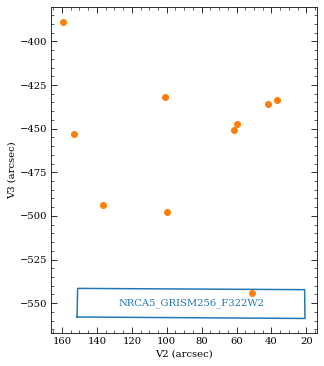

In [62]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ap_siaf.plot(frame='tel', mark_ref=False, ax=ax, label=True, fill=False)

ax.plot(v2_obj[mask], v3_obj[mask], marker='o', ls='none')

# fig.tight_layout()

In [67]:
siaf_ap = tel_pointing.siaf_ap_obs
ra_ref, dec_ref = (tel_pointing.ra_obs, tel_pointing.dec_obs)
att = tel_pointing.attitude_matrix(idl_off=idl_off[0], ap_siaf_ref=siaf_ap, coord_ref=(ra_ref, dec_ref))

In [ ]:
NRCA5_GRISM256_F322W2
NRCA5_GRISM128_F322W2
NRCA5_GRISM64_F322W2
NRCA5_GRISM256_F277W
NRCA5_GRISM128_F277W
NRCA5_GRISM64_F277W
NRCA5_GRISM256_F356W
NRCA5_GRISM128_F356W
NRCA5_GRISM64_F356W
NRCA5_GRISM256_F444W
NRCA5_GRISM128_F444W
NRCA5_GRISM64_F444W
NRCA5_GRISM_F322W2
NRCA5_GRISM_F277W
NRCA5_GRISM_F356W
NRCA5_GRISM_F444W
NRCA1_GRISMTS
NRCA1_GRISMTS256
NRCA1_GRISMTS128
NRCA1_GRISMTS64
NRCA3_GRISMTS
NRCA3_GRISMTS256
NRCA3_GRISMTS128
NRCA3_GRISMTS64
NRCA5_TAGRISMTS32
NRCA5_TAGRISMTS32_F405N
NRCA5_TAGRISMTS_SCI_F322W2
NRCA5_TAGRISMTS_SCI_F444W
NRCB5_GRISM256_F322W2
NRCB5_GRISM128_F322W2
NRCB5_GRISM64_F322W2

Ref Point (64 pix): (1580.9877721612831, 280.00447976852183)
Ref Point (128 pix): (1580.9877721612831, 280.00447976852183)
Ref Point (256 pix): (1580.9877721612831, 280.00447976852183)


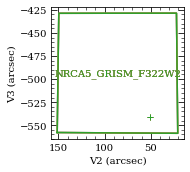

In [89]:
import pysiaf
siaf = pysiaf.Siaf('NIRCam')


fig, ax = plt.subplots(1,1, figsize=(14,2.5))
for sz in [64, 128, 256]:
    ap_siaf = siaf[f'NRCA5_GRISM_F322W2']
    ap_siaf.plot(frame='tel', mark_ref=True, ax=ax, label=True)
    print(f"Ref Point ({sz} pix):", ap_siaf.reference_point('sci'))

fig.tight_layout()

In [66]:
siaf_ap.set_attitude_matrix(att)
siaf_ap.convert(ra_ref, dec_ref, 'sky', 'sci')

(1580.9859008012788, 35.007956286030854)

In [68]:
siaf_ap.set_attitude_matrix(att)
siaf_ap.convert(ra_ref, dec_ref, 'sky', 'sci')

(1581.7628256728124, -1.727724593589457)

In [54]:
tel_pointing.siaf_ap_ref.set_attitude_matrix()

(50.767712, -556.476341)

In [55]:
v2_obj, v3_obj

((array([  50.70880098,  213.15915237,  228.41647918, -203.25185495]),
  array([-558.84346179, -629.56374187, -738.29901118, -391.89264841])),
 (array([  50.86992474,  213.32024112,  228.57755795, -203.09069736]),
  array([-544.10584528, -614.82612992, -723.56140013, -377.15504307])))

In [49]:
v2_obj

(array([  50.70880098,  213.15915237,  228.41647918, -203.25185495]),
 array([-558.84346179, -629.56374187, -738.29901118, -391.89264841]))

In [39]:
ra_deg, dec_deg

(array([146.8762375 , 146.81478027, 146.842714  , 146.95336467]),
 array([63.24721111, 63.28792868, 63.315727  , 63.17027856]))

In [40]:
xpix

array([ 1581.76282567,  -914.03368401, -1010.24502393,  5349.3690722 ])

In [41]:
ypix

array([-1.72772459e+00, -1.10559412e+03, -2.61271615e+03,  2.41745145e+03])

In [ ]:
# def gen_grism_image(nrc, tel_pointing, ra_deg, dec_deg, mags, 
#                     expnum=1, osamp=1, siaf_ap_obs=None, **kwargs):

#     """ Create an unconvolved image with sub-pixel shifts
#     
#     """    
from pynrc.obs_nircam import attenuate_with_coron_mask, gen_coron_mask
    
    # Observation aperture
    siaf_ap_obs = nrc.siaf_ap if siaf_ap_obs is None else siaf_ap_obs
    ap_obs_name = siaf_ap_obs.AperName
    
    # Get all source fluxes
    # mags = tbl[nrc.filter].data
    flux_obj = mag_to_counts(mags, nrc.bandpass, **kwargs)

    if isinstance(expnum, str):
        expnum = int(expnum)
    
    ind = np.where(tel_pointing.exp_nums == expnum)[0][0]

    # Convert RA, Dec coordiantes into V2/V3 (arcsec)
    # ra_deg, dec_deg = (tbl['ra'], tbl['dec'])
    idl_off = [tel_pointing.position_offsets_act[ind]]
    v2_obj, v3_obj = tel_pointing.radec_to_frame((ra_deg, dec_deg), frame_out='tel', idl_offsets=idl_off)
    
    # Create initial POM image, then contract to reasonable size
    xsci, ysci, im_pom = pickoff_image(ap_obs_name, v2_obj, v3_obj, flux_obj, oversample=osamp)

    # Crop based on subarray window size
    # Maximum required size depends on PSF and detector readout size

    # Min and max sci coordinates to keep
    xmin = ymin = int(-nrc.fov_pix/2 - 1)
    xmax = int(siaf_ap_obs.XSciSize + nrc.fov_pix/2 + 1)
    ymax = int(siaf_ap_obs.YSciSize + nrc.fov_pix/2 + 1)

    xmask = (xsci>=xmin) & (xsci<xmax)
    ymask = (ysci>=ymin) & (ysci<ymax)

    # Keep only regions that contribute to final convolved image
    xsci = xsci[xmask]
    ysci = ysci[ymask]
    im_sci = im_pom[ymask][:,xmask]
    
    # Make science image HDUList from 
    hdul_sci_image = fits.HDUList([fits.PrimaryHDU(im_sci)])
    hdul_sci_image[0].header['PIXELSCL'] = nrc.pixelscale / osamp
    hdul_sci_image[0].header['OSAMP'] = osamp
    hdul_sci_image[0].header['INSTRUME'] = nrc.name
    hdul_sci_image[0].header['APERNAME'] = ap_obs_name
    
    # Get X and Y indices corresponding to aperture reference
    xind_ref = np.argmin(np.abs(xsci - siaf_ap_obs.XSciRef))
    yind_ref = np.argmin(np.abs(ysci - siaf_ap_obs.YSciRef))
    hdul_sci_image[0].header['XIND_REF'] = (xind_ref, "x index of aperture reference")
    hdul_sci_image[0].header['YIND_REF'] = (yind_ref, "y index of aperture reference")
    hdul_sci_image[0].header['XSCI0']    = (np.min(xsci), "xsci value at (x,y)=(0,0) corner")
    hdul_sci_image[0].header['YSCI0']    = (np.min(ysci), "ysci value at (x,y)=(0,0) corner")
    hdul_sci_image[0].header['CFRAME'] = 'sci'

    # print(im_pom.shape, im_sci.shape)
    
    return hdul_sci_image


In [ ]:
def place_grism_source(waves, imarr, (xsci, ysci), wref=None, im_coords='sci'):
    """
    Shift image such that undeviated wavelength sits at the
    desired pixel location
    """
    
    from .maths.coords import det_to_sci

    if len(imarr.shape) > 2:
        nz, ny_in, nx_in = imarr.shape
    else:
        nz = 1
        ny_in, nx_in = imarr.shape
        imarr = imarr.reshape([nz,ny_in,nx_in])
    
    # Convert to sci coordinates
    if im_coords=='det':
        det_name = siaf_ap.AperName[3:5]
        imarr = det_to_sci(imarr, det_name)

    # Determine reference wavelength
    if wref is None:
        if 'GRISMC' in siaf_ap.AperName:
            pupil = 'GRISMC'
        elif 'GRISM' in siaf_ap.AperName:
            pupil = 'GRISMR'
        else: # generic grism
            pupil = 'GRISM'
        module = 'A' if 'NRCA' in siaf_ap.AperName else 'B'
        wref = grism_wref(pupil, module)

    # Get reference coordinates
    yref, xref = (siaf_ap.YSciRef, siaf_ap.XSciRef)
    
    # Final image size
    ny_out, nx_out = (siaf_ap.YSciSize, siaf_ap.XSciSize)
    
    # Empirically determine shift value in dispersion direction
    wnew_temp = pad_or_cut_to_size(waves, nx_out)
    
    # Index of reference wavelength associated with ref pixel
    ind = (wnew_temp>wref-0.01) & (wnew_temp<wref+0.01)
    xnew_temp = np.interp(wref, wnew_temp[ind], np.arange(nx_out)[ind])
    xoff = xref - xnew_temp
    
    # Move to correct position in y
    yoff = yref - (int(ny_out/2) - 1)
    # if np.mod(ny_in,2)==0: # If even, shift by half a pixel?
    #     yoff = yoff + 0.5
    
    imarr = pad_or_cut_to_size(imarr, (ny_out,nx_out), offset_vals=(yoff,xoff), fill_val=np.nan)
    waves = pad_or_cut_to_size(waves, nx_out, offset_vals=xoff, fill_val=np.nan)
    
    # Remove NaNs
    ind_nan = np.isnan(imarr)
    imarr[ind_nan] = np.min(imarr[~ind_nan])
    # Remove NaNs
    # Fill in with wavelength solution (linear extrapolation)
    ind_nan = np.isnan(waves)
    # waves[ind_nan] = 0
    arr = np.arange(nx_out)
    cf = jl_poly_fit(arr[~ind_nan], waves[~ind_nan])
    waves[ind_nan] = jl_poly(arr[ind_nan], cf)

    return waves, imarr


In [98]:
test = nrc_utils.grism_background_image('F335M', pupil='GRISM90')

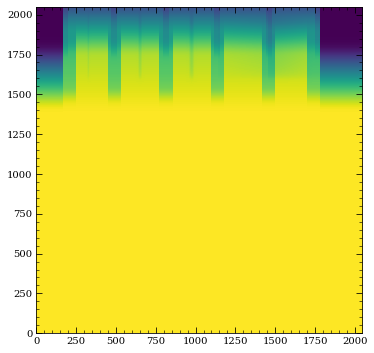

In [99]:
plt.imshow(test)

In [79]:
xpix, ypix

(array([ 1581.73919896,  2312.37829322,   812.26926264,  2270.16840185,
          533.59975454,  1415.74118326,  1448.89733903,   224.26145579,
         1730.08401058,  1815.35156691,   432.01195402,  1643.71750116,
         2309.40697322,  -267.81454022,   790.69520841,   -46.20518968,
         3606.66150519,  1115.62939092,  2720.86067823,   220.08987804,
         -914.02242899,  1340.64276708,   363.4733483 ,  3627.42265162,
         3622.65013922, -1261.39945926,   385.12478414,  3548.84094056,
         -153.14369032,  3733.11084772,  4407.44070153,   222.87480125,
        -1436.12103464,  -814.30689115, -1001.93254452,   618.52844288,
        -1355.83588339,  -102.74735641,  4384.26743663, -1095.75259516,
          637.67864206,  1937.4974786 , -1668.18943661,  -277.29548035,
        -1647.56219666, -1736.56694866,  2362.23372884,  1676.29241976,
         4813.86609197,   -91.88555892,  3333.74651004, -1884.32293151,
         2505.01562529,  4720.47505922,  -628.03868109,  4826.86

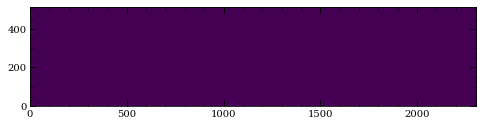

In [73]:
plt.imshow(hdul[0].data**0.2)

In [63]:
src_tbl[nrc.filter].data

array([ 4.753, 18.013, 16.975, 16.422, 16.991, 19.32 , 18.141, 19.062,
       17.227, 18.983, 16.202, 16.628, 15.85 , 16.83 , 18.782, 16.408,
       15.977, 16.971, 19.412, 15.611, 12.047, 16.857, 16.982, 17.348,
       13.523, 19.049, 18.95 , 18.86 , 14.995, 16.937, 13.9  , 14.769,
       16.886, 18.856, 16.232, 19.148, 15.042, 16.437, 16.106, 15.16 ,
       17.565, 17.233, 18.848, 18.449, 16.354, 17.513, 19.159, 18.457,
       17.977, 16.903, 15.018, 19.266, 17.259, 18.84 , 13.488, 15.878,
       17.067, 16.933, 16.292, 16.834, 14.101, 17.703, 13.878, 19.526,
       19.032, 18.464, 12.827, 16.701, 18.424, 16.846, 16.838, 14.384,
       16.337, 18.837,  8.838, 19.469, 17.327, 15.58 , 19.006, 16.908,
       16.665, 17.08 , 15.637, 14.307, 13.961, 19.155, 17.758, 14.994,
       17.606, 16.802, 16.378, 16.785, 18.298, 16.57 , 19.417, 13.935,
       16.133, 18.974, 14.992, 14.265, 18.8  , 17.062, 15.59 , 14.968,
       16.153, 17.591, 18.547, 19.458, 17.345, 18.932, 19.158, 16.383,
      

In [49]:
visit_dict

{'obs_num': 1,
 'visit_num': 1,
 'visit_start': 23416,
 'slew_duration': 1800,
 'visit_duration': 1167,
 'exp_start_times': array([25418, 25928]),
 'APTTemplate': 'NircamEngineeringImaging',
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_dith': 1651531080,
 'rand_seed_noise': 1148333065,
 'TargetID': array(['HD-84406', 'HD-84406'], dtype='<U15'),
 'TargetRA': array(['09:47:30.2970', '09:47:30.2970'], dtype='<U13'),
 'TargetDec': array(['+63:14:49.96', '+63:14:49.96'], dtype='<U12'),
 'aperture': array([['N

In [48]:
tel_point.position_offsets_act

[array([ 0.0503554 , -2.36010486]), array([-0.05275878, 12.37800296])]

In [38]:
det = obs_params['det_obj']
kw = res = {**det.to_dict(), **det.multiaccum.to_dict()}
nrc.update_detectors(**kw)

In [40]:
nrc.det_info

{'wind_mode': 'WINDOW',
 'nout': 1,
 'xpix': 2048,
 'ypix': 256,
 'x0': 0,
 'y0': 0,
 'read_mode': 'RAPID',
 'nint': 10,
 'ngroup': 5,
 'nf': 1,
 'nd1': 0,
 'nd2': 0,
 'nd3': 0}

In [34]:
det.to_dict()

{'wind_mode': 'WINDOW', 'nout': 1, 'xpix': 2048, 'ypix': 256, 'x0': 0, 'y0': 0}

In [35]:
det.multiaccum.to_dict()

{'read_mode': 'RAPID',
 'nint': 10,
 'ngroup': 5,
 'nf': 1,
 'nd1': 0,
 'nd2': 0,
 'nd3': 0}

In [31]:
nrc.det_info

{'wind_mode': 'STRIPE',
 'nout': 4,
 'xpix': 2048,
 'ypix': 256,
 'x0': 0,
 'y0': 0,
 'read_mode': 'RAPID',
 'nint': 1,
 'ngroup': 1,
 'nf': 1,
 'nd1': 0,
 'nd2': 0,
 'nd3': 0}

In [33]:
import pysiaf
siaf = pysiaf.Siaf('NIRCam')
for k in list(siaf.apernames):
    if 'GRISM' in k:
        print(k)

NRCA5_GRISM256_F322W2
NRCA5_GRISM128_F322W2
NRCA5_GRISM64_F322W2
NRCA5_GRISM256_F277W
NRCA5_GRISM128_F277W
NRCA5_GRISM64_F277W
NRCA5_GRISM256_F356W
NRCA5_GRISM128_F356W
NRCA5_GRISM64_F356W
NRCA5_GRISM256_F444W
NRCA5_GRISM128_F444W
NRCA5_GRISM64_F444W
NRCA5_GRISM_F322W2
NRCA5_GRISM_F277W
NRCA5_GRISM_F356W
NRCA5_GRISM_F444W
NRCA1_GRISMTS
NRCA1_GRISMTS256
NRCA1_GRISMTS128
NRCA1_GRISMTS64
NRCA3_GRISMTS
NRCA3_GRISMTS256
NRCA3_GRISMTS128
NRCA3_GRISMTS64
NRCA5_TAGRISMTS32
NRCA5_TAGRISMTS32_F405N
NRCA5_TAGRISMTS_SCI_F322W2
NRCA5_TAGRISMTS_SCI_F444W
NRCB5_GRISM256_F322W2
NRCB5_GRISM128_F322W2
NRCB5_GRISM64_F322W2
NRCB2_GRISMTS256
NRCB2_GRISMTS128
NRCB2_GRISMTS64
NRCB4_GRISMTS256
NRCB4_GRISMTS128
NRCB4_GRISMTS64
NRCA5_GRISMC_WFSS
NRCA5_GRISMR_WFSS
NRCALL_GRISMC_WFSS
NRCALL_GRISMR_WFSS
NRCB5_GRISMC_WFSS
NRCB5_GRISMR_WFSS
NRCA5_GRISMR_WFSS_F250M_CS
NRCB5_GRISMR_WFSS_F250M_CS
NRCA5_GRISMR_WFSS_F277W_CS
NRCB5_GRISMR_WFSS_F277W_CS
NRCA5_GRISMR_WFSS_F300M_CS
NRCB5_GRISMR_WFSS_F300M_CS
NRCA5_GRISMR_WFS

In [15]:
arr = np.array([1,2])
ind_mask = arr==1


In [16]:
ind_mask

array([ True, False])

In [12]:
visit_dict = visits['001:001']

In [22]:
visit_dict['aperture'][ind_mask]

1

In [30]:
np.where(visit_dict['detectors'][ind_mask] == 'NRCA5')

(array([0]), array([4]))

In [36]:
np.where(visit_dict['detectors'][ind_mask].flatten() == 'NRCA5')

(array([4]),)

In [38]:
ind_det = np.where(visit_dict['detectors'][ind_mask] == 'NRCA5')
visit_dict['apertures'][ind_mask][ind_det][0]

'NRCA5_GRISM256_F322W2'

In [ ]:
apname = visit_dict['aperture'][ind_mask][0]

In [20]:
visits['022:001']

{'obs_num': 22,
 'visit_num': 1,
 'visit_start': 26383,
 'slew_duration': 51,
 'visit_duration': 1451,
 'exp_start_times': array([26626, 27384]),
 'APTTemplate': 'NircamEngineeringImaging',
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_dith': 437753479,
 'rand_seed_noise': 3771821479,
 'TargetID': array(['HD-84406', 'HD-84406'], dtype='<U15'),
 'TargetRA': array(['09:47:30.2970', '09:47:30.2970'], dtype='<U13'),
 'TargetDec': array(['+63:14:49.96', '+63:14:49.96'], dtype='<U12'),
 'aperture': array(['NRCA

In [10]:
obs_params = apt_obj.gen_obs_params('001:001', '00001', 'NRCA5', grp_id=2)

In [11]:
obs_params

{'pi_name': 'Erin Smith',
 'title': 'CAR_NIRCAM-0035: NIRCAM Ice Measurement',
 'category': 'COM',
 'sub_category': 'NIRCAM',
 'science_category': 'Stellar Physics',
 'target_name': 'HD-84406',
 'catalog_name': 'UNKNOWN',
 'ra': 146.8762375,
 'dec': 63.24721111111111,
 'pa_v3': 161.5806619288712,
 'roll_offset': 0,
 'solar_elong': 123.12452583911617,
 'pitch_ang': 33.124525839116174,
 'siaf_ap': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_obs': 146.8766636399694,
 'dec_obs': 63.24658117907037,
 'siaf_ap_ref': <pysiaf.Aperture object AperName=NRCA5_GRISM256_F322W2 >,
 'ra_ref': 146.8766636399694,
 'dec_ref': 63.24658117907037,
 'date-obs': '2022-03-01',
 'time-obs': '12:00:00.000',
 'obs_id_info': {'program_number': '01409',
  'observation_number': '001',
  'visit_number': '001',
  'visit_group': '02',
  'sequence_id': '1',
  'activity_id': '01',
  'exposure_number': '00001',
  'visit_id': '01409001001',
  'obs_id': 'V01409001001P0000000002101'},
 'obs_label': 'LW Gri

In [9]:
visits['001:001']

{'obs_num': 1,
 'visit_num': 1,
 'visit_start': 23416,
 'slew_duration': 1800,
 'visit_duration': 1167,
 'exp_start_times': array([25418, 25928]),
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_dith': 3710271437,
 'rand_seed_noise': 191294463,
 'TargetID': array(['HD-84406', 'HD-84406'], dtype='<U15'),
 'TargetRA': array(['09:47:30.2970', '09:47:30.2970'], dtype='<U13'),
 'TargetDec': array(['+63:14:49.96', '+63:14:49.96'], dtype='<U12'),
 'aperture': array(['NRCA5_GRISM256_F322W2', 'NRCA5_GRISM256_F322W2'

In [16]:
det_amod = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCA5']
det_amod[0:4]

['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4']

In [15]:
for k in visits.keys():
    print(k, visits[k]['detectors'])

003:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
002:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
004:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
009:001 [['NRCA5']
 ['NRCA5']]
008:001 [['NRCA5']
 ['NRCA5']]
007:001 [['NRCA5']
 ['NRCA5']]
005:001 [['NRCA5']
 ['NRCA5']]
006:001 [['NRCA5']
 ['NRCA5']]
031:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']
 ['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
032:001 [['NRCA5']
 ['NRCA5']]
033:001 [['NRCA5']
 ['NRCA5']]
034:001 [['NRCA5']]
001:001 [['NRCA5']
 ['NRCA5']]
022:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']
 ['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
023:001 [['NRCA1' 'NRCA2' 'NRCA3' 'NRCA4' 'NRCA5']]
024:001 [['NRCB5']
 ['NRCB5']]
025:001 [['NRCBS']
 ['NRCBS']]
026:001 [['NRCBS']]


In [10]:
visits['008:001']

{'obs_num': 8,
 'visit_num': 1,
 'visit_start': 8533,
 'slew_duration': 265,
 'visit_duration': 1326,
 'exp_start_times': array([9122, 9655]),
 'PrimaryDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'PrimaryDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherSize': array(['NONE', 'NONE'], dtype='<U4'),
 'SubpixelPositions': array(['1', '1'], dtype='<U1'),
 'SubpixelDitherType': array(['STANDARD', 'STANDARD'], dtype='<U8'),
 'SmallGridDitherType': array(['NONE', 'NONE'], dtype='<U4'),
 'DitherPatternType': array(['NONE', 'NONE'], dtype='<U4'),
 'ImageDithers': array(['NONE', 'NONE'], dtype='<U4'),
 'number_of_dithers': array(['1', '1'], dtype='<U1'),
 'rand_seed_dith': 3267179548,
 'rand_seed_noise': 2965660561,
 'TargetID': array(['GCRV-21765', 'GCRV-21765'], dtype='<U15'),
 'TargetRA': array(['05:49:53.4300', '05:49:53.4300'], dtype='<U13'),
 'TargetDec': array(['-64:32:24.00', '-64:32:24.00'], dtype='<U12'),
 'aperture': array(['NRCA5_GRISM256_F322W2', 'NRCA5_GRISM256_F322W2

In [9]:
visits.keys()

odict_keys(['003:001', '002:001', '004:001', '009:001', '008:001', '007:001', '005:001', '006:001', '031:001', '032:001', '033:001', '034:001', '001:001', '022:001', '023:001', '024:001', '025:001', '026:001'])

  Generating Observation...


Single PSFs:   0%|          | 0/21 [00:00<?, ?it/s]

In [17]:
# Update detector information
obs.update_detectors(wind_mode='STRIPE', ypix=256, read_mode='RAPID', ngroup=10, nint=5)
d['obs'] = obs

# Create ideal spectral slope images
#############################################
print('  Creating ideal slope image...')
T = d['temp']

  Creating ideal slope image...


In [20]:
# Modify flux due to lower effective collecting area
input_pupil_hdul, input_opd_hdul = d['opd']
coll_area_seg = 25.78e4 * input_pupil_hdul[0].data.sum() / pupil_hdul[0].data.sum()
# S.refs.setref(area=coll_area_seg)


In [15]:
%time psf = obs.calc_psf_from_coeff(return_oversample=False)

CPU times: user 4.11 s, sys: 1.77 s, total: 5.87 s
Wall time: 3.3 s


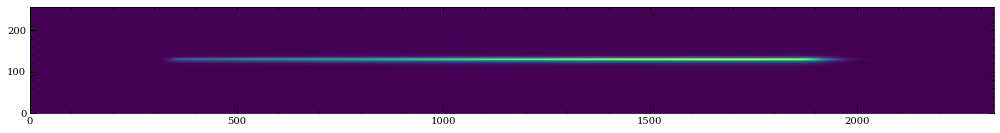

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14,2.5))

ax.imshow(psf[0].data)

fig.tight_layout()

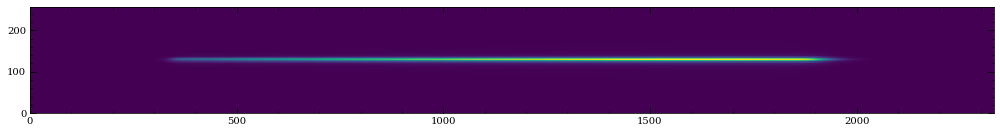

In [14]:
fig, ax = plt.subplots(1,1, figsize=(14,2.5))

ax.imshow(psf[0].data)

fig.tight_layout()

In [27]:
bg = obs.bg_zodi_image()
bg /= bg.max()
bg *= 1000

In [28]:
bg.max()

1000.0

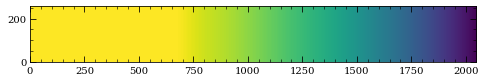

In [29]:
plt.imshow(bg)

In [21]:
psf.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DET_DIST      1 PrimaryHDU      78   (2332, 257)   float64   
  1  WAVELENGTHS    1 ImageHDU         7   (2332,)   float64   


In [ ]:
opd_dict = inst.get_opd_info()